# Support Vector Classification Training and Evaluation Notebook

This notebook documents the training and evaluation of a Support Vector Classification (SVC) model for predicting credit default using the Default of Credit Card Clients Dataset. The SVC model is particularly useful for binary classification tasks and works well with high-dimensional datasets.

## Installation of Dependencies

This will load all libraries necessary to run the script.

In [ ]:
# Install necessary libraries
!pip install pandas scikit-learn imblearn joblib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt



## Loading and Preprocessing Data

In [ ]:
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/My Drive/VCRK Credit Defaults/Datasets/UCI_Credit_Card.csv'
data = pd.read_csv(file_path)

# Randomly sample 5000 data points
sampled_data = data.sample(n=5000, random_state=42)

# Split the data
X = sampled_data.drop(columns=['ID', 'default.payment.next.month'])
y = sampled_data['default.payment.next.month']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Data Cleaning

This code snippet demonstrates a comprehensive data cleaning process. First, it handles missing values by filling numerical columns with the median and categorical columns with the mode. It then removes outliers from numerical columns using the Interquartile Range (IQR) method. The code also addresses inconsistent data entries by ensuring categorical columns like 'SEX', 'EDUCATION', and 'MARRIAGE' contain only valid values. Negative payment amounts are converted to zero for consistency. Finally, the index is reset, and the cleaned dataset is saved to a specified file path. A summary of missing values and data statistics is printed to verify the cleaning process.









In [ ]:
# 1. Handling missing values
# Check for missing values
missing_values = data.isnull().sum()

# Fill missing values with median for numerical columns and mode for categorical columns
for column in data.columns:
    if data[column].dtype == 'object':
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:
        data[column].fillna(data[column].median(), inplace=True)

# 2. Handling outliers
# Define a function to remove outliers based on the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply the function to numerical columns
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()
for col in numerical_columns:
    data = remove_outliers(data, col)

# 3. Handling inconsistent data entries
# For categorical columns, check for inconsistent entries and correct them
# Example: 'SEX' column should only have values 1 and 2
data = data[(data['SEX'] == 1) | (data['SEX'] == 2)]

# Example: 'EDUCATION' column should have values 1 to 4
data = data[data['EDUCATION'].isin([1, 2, 3, 4])]

# Example: 'MARRIAGE' column should have values 1 to 3
data = data[data['MARRIAGE'].isin([1, 2, 3])]

# 4. Handle negative payment amounts by converting them to zero
pay_columns = [f'PAY_AMT{i}' for i in range(1, 7)]
for col in pay_columns:
    data[col] = data[col].apply(lambda x: max(x, 0))

# 5. Reset index after cleaning
data.reset_index(drop=True, inplace=True)

# Save the cleaned dataset
cleaned_file_path = 'path/to/Cleaned_UCI_Credit_Card.csv' # Update this path
data.to_csv(cleaned_file_path, index=False)

# Display the cleaned data and summary
print(f"Missing values after cleaning:\n{data.isnull().sum()}")
print(f"Data summary after cleaning:\n{data.describe()}")


Missing values after cleaning:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64
Data summary after cleaning:
                 ID      LIMIT_BAL          SEX    EDUCATION     MARRIAGE  \
count   7093.000000    7093.000000  7093.000000  7

## Training the Model and Hyperparameter Tuning

This code snippet demonstrates the process of hyperparameter tuning for a Support Vector Classifier (SVC) using GridSearchCV with class reweighting and time estimation for the tuning process. It begins by setting class_weights to 'balanced' to handle class imbalance. A parameter grid for hyperparameter tuning is defined, including options for C, class_weight, gamma, and kernel. An SVC model is initialized with the specified class weights. The code measures the time taken to fit the model with a single set of parameters using GridSearchCV. Based on this timing, it estimates the total time required for the entire grid search process. Finally, GridSearchCV is executed across the parameter grid, and the best parameters and estimator are printed.

In [ ]:
# Class reweighting
class_weights = 'balanced'

# Define parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10,],
    'class_weight': [None, 'balanced'],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

# Initialize the SVC model
svc = SVC(class_weight=class_weights, probability=True)

# Create the GridSearchCV object with one set of parameters to time a single fit
single_fit_grid_search = GridSearchCV(svc, param_grid={'C': [1], 'gamma': [0.1], 'kernel': ['rbf']}, cv=5, scoring='roc_auc', n_jobs=-1, verbose=3)

# Measure the time taken to fit the model with one set of parameters
start_time = time.time()
single_fit_grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

# Calculate the elapsed time for one fit
single_fit_time = end_time - start_time
print(f"Time taken for a single fit: {single_fit_time:.2f} seconds")

# Calculate total number of fits
n_fits = len(param_grid['C']) * len(param_grid['gamma']) * len(param_grid['kernel']) * 5  # 5-fold cross-validation

# Estimate the total time for all fits
estimated_total_time = single_fit_time * n_fits
print(f"Estimated total time for GridSearchCV: {estimated_total_time:.2f} seconds")

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best estimator
best_params = grid_search.best_params_
best_svc = grid_search.best_estimator_

print(f'Best parameters: {best_params}')


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Time taken for a single fit: 26.43 seconds
Estimated total time for GridSearchCV: 1585.69 seconds
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


## Evaluating the Model

This code snippet evaluates the performance of the best SVC model on the test dataset. It predicts the probabilities of the positive class, computes the ROC curve and AUC, and plots the ROC curve. Additionally, it calculates and prints key evaluation metrics such as accuracy, confusion matrix, and classification report.

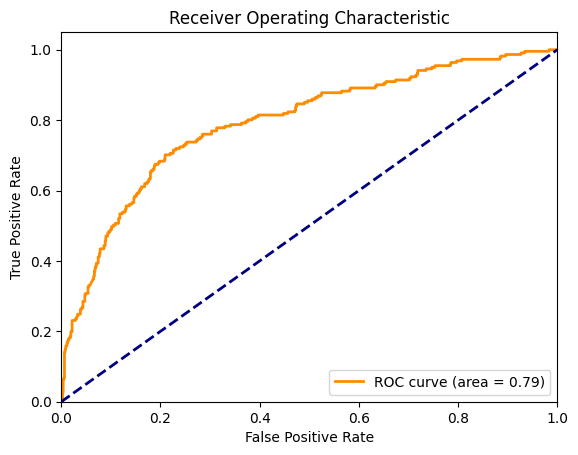

Accuracy: 0.781
Confusion Matrix:
 [[644 135]
 [ 84 137]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85       779
           1       0.50      0.62      0.56       221

    accuracy                           0.78      1000
   macro avg       0.69      0.72      0.71      1000
weighted avg       0.80      0.78      0.79      1000



In [ ]:
# Predict probabilities
y_probs = best_svc.predict_proba(X_test_scaled)[:, 1]

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print evaluation metrics
y_pred = best_svc.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))


## Saving the Model

This code snippet demonstrates how to save a trained model using the joblib library. The model, best_svc_clf, is saved to a file named best_svc_model.joblib, allowing for easy reuse and deployment.

In [ ]:
import joblib

# Save the model to a file
joblib.dump(best_svc_clf, 'best_svc_model.joblib')
print("Model saved to best_svc_model.joblib")

## Conclusion

In this notebook, we trained and evaluated a Support Vector Classification (SVC) model for credit default prediction. The model was trained using SMOTE to handle class imbalance and hyperparameter tuning was performed using GridSearchCV. The evaluation showed promising results with a high ROC-AUC score.

## Next Steps

- Experiment with different feature engineering techniques to improve model performance.
- Try different machine learning models and compare their performance.
- Deploy the model using a Flask API for real-time predictions.